# One-class SVM

>One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

[Scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html)

In [1]:
# Do the math ! Do the math !
import pandas as pd
import numpy as np

# Matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import ListedColormap

# IPython widgets and display
from IPython.display import display
import ipywidgets as widgets

# Every scikit-learn import
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid

from Data import Data

In [2]:
data = Data()

columns = ["rrTime" + str(index) for index in range(15)]
columns.extend(["ppTime" + str(index) for index in range(15)])
columns.extend(["rpTime" + str(index) for index in range(15)])
columns.extend(["prTime" + str(index) for index in range(15)])

xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(58)]).T

## Extracting the data

In [3]:
user = widgets.Dropdown(options=data.users, value=1, description='User:', disabled=False)
display(user)

Dropdown(description='User:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

Choose the user tested in the One-Class SVM. The user's index will be used to build a training and testing set solely containing samples from the chosen user.

The rest of the data will be used as outliers.

In [4]:
# We select the data of the user
studiedUserData = data.table.loc[(data.table["user_id"] == user.value), columns].astype('float')
# We create a random boolean mask to select around 80% of the data
studiedUserMsk = np.random.rand(len(studiedUserData)) < 0.8
# We select the rest of the data. It will be used as outliers.
otherUsersData = data.table.loc[(data.table["user_id"] != user.value), columns].astype('float')

# Training and testing data are for training on and testing normal data
X_train = studiedUserData[studiedUserMsk]
X_test = studiedUserData[~studiedUserMsk]

# Abnormal data (used only for prediction)
X_outliers = otherUsersData

# According to https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
# data for SVM should be linearly scaled to the range [0, 1] or [-1, 1]
# Also, the scaler should be fitted on the training data only before transforming
# the rest of the data
scaler = MinMaxScaler((0, 1))
scaler.fit(X_train)

# Scaling the data. We use the scaler that have been fitted to the training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_outliers = scaler.transform(X_outliers)

## Creating and training the SVM

In [19]:
def learn(train, test, outliers, nu=0.01, gamma=0.01):
    # Fit the One Class SVM model
    # In the case where there is much more samples than features, rbf kernel
    # is usually the way to go. Setting the kernel to linear raised A LOT of
    # false positive on abnormal data (~97% !!)
    clf = OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(X_train)
    
    # Predict on all data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers = clf.predict(X_outliers)
    
    TP = y_pred_test[y_pred_test == 1].size
    TN = y_pred_outliers[y_pred_outliers == -1].size
    FP = y_pred_outliers[y_pred_outliers == 1].size
    FN = y_pred_test[y_pred_test == -1].size
    
    returned = {
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "FNT": y_pred_train[y_pred_train == -1].size,
        "precision": TP / (TP + FP + 1),
        "recall": TP / (TP + FN + 1),
        "f1": (2 * TP) / (2 * TP + FP + FN),
        "clf": clf
    }
    
    return returned

results = learn(X_train, X_test, X_outliers)

print("False negative on training data : {0}/{1}, {2:.3f}%".format(results["FNT"],
                                                                  X_train.shape[0],
                                                                  results["FNT"] / X_train.shape[0] * 100))
print("False negative on testing data : {0}/{1}, {2:.3f}%".format(results["FN"],
                                                                 X_test.shape[0],
                                                                 results["FN"] / X_test.shape[0] * 100))
print("False positive on abnormal data : {0}/{1}, {2:.3f}%".format(results["FP"],
                                                                  X_outliers.shape[0],
                                                                  results["FP"] / X_outliers.shape[0] * 100))

print("precision: {},\nrecall: {},\nf1: {}".format(results["precision"], results["recall"], results["f1"]))

False negative on training data : 4/46, 8.696%
False negative on testing data : 1/9, 11.111%
False positive on abnormal data : 67/3715, 1.803%
precision: 0.10526315789473684,
recall: 0.8,
f1: 0.19047619047619047


## Plotting the decision function

Apparently, this is not very significative. When the 60-dimensional points are projected on a 2-dimensional plane, abnormal data overlap the area included inside the decision function.

Plus, I do have issues for plotting the frontiers.

/media/data/rodolphe/Documents/Etudes/ISEN/AP4/Projet/data/env/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


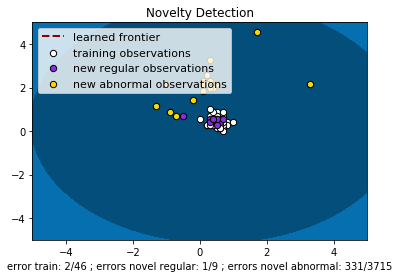

In [20]:
Z = clf.decision_function(Xpred)
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
#plt.contourf(xx, yy, Z, levels=np.linspace(0, Z.max(), 7), colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:20, 0], X_outliers[:20, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier",
            "training observations",
            "new regular observations",
            "new abnormal observations"],
           loc="upper left", prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel("error train: %d/%d ; errors novel regular: %d/%d ; errors novel abnormal: %d/%d" % (n_error_train, X_train.shape[0], n_error_test, X_test.shape[0], n_error_outliers, X_outliers.shape[0]))
plt.show()

## Searching the best parameters with cross-validation

In [23]:
grid = {'gamma' : np.logspace(-9, 3, 13),
        'nu' : np.linspace(0.01, 0.99, 99)}

smallestDiff = 1.0
smallestDiffParameters = None

biggestF1 = 0

for hyperparams in ParameterGrid(grid):
    results = learn(X_train, X_test, X_outliers, nu=hyperparams["nu"], gamma=hyperparams["gamma"])
    
    far = results["FP"] / X_outliers.shape[0]
    frr = results["FN"] / X_test.shape[0]
    
    if abs(far - frr) < smallestDiff:
        smallestDiff = abs(far - frr)
        smallestDiffParameters = hyperparams
        
    print("gamma: {}\tnu: {:.3f}\tprecision: {:.3f}\trecall: {:.3f}\tf1: {:.3f}".format(
        hyperparams["gamma"], hyperparams["nu"], results["precision"], results["recall"], results["f1"]
    ))
    
    if results["f1"] > biggestF1:
        biggestF1 = results["f1"]

print("Smallest diff: {}".format(smallestDiff))
print("Smallest diff parameters: {}".format(smallestDiffParameters))
print("Biggest f1: {}".format(biggestF1))

gamma: 1e-09	nu: 0.010	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.020	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.030	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.040	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.050	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.060	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.070	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.080	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.090	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.100	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.110	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.120	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.130	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.140	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.150	precision: 0.000	recall: 0.000	f1: 0.000
gamma: 1e-09	nu: 0.160	precision: 0.000	

## Metrics

According to this page : https://stats.stackexchange.com/questions/192530/metrics-for-one-class-classification

According to Lee, Wee Sun, and Bing Liu. "Learning with positive and unlabelled examples using weighted logistic regression." ICML. Vol. 3. 2003. (creators of One-Class SVM)

The best formula may be :

\begin{equation*}
\frac{r^2}{\Pr(Y=1)}
\end{equation*}